## Набор данных
Набор данных, который я выбрал, — это набор данных об изменах, который поставляется со Statsmodels. Он был получен в результате опроса женщин, проведенного в 1974 году журналом Redbook, в ходе которого замужних женщин спрашивали об их участии во внебрачных связях. Более подробная информация об исследовании доступна в статье 1978 года в журнале «Political Economy».

## Описание переменных
Набор данных содержит 6366 наблюдений 9 переменных:

- rate_marriage: оценка женщиной своего брака (1 = очень плохо, 5 = очень хорошо)
- age: женский возраст
- yrs_married: количество лет в браке
- children: количество детей
- religious: оценка женщиной того, насколько она религиозна (1 = не религиозна, 4 = сильно религиозна)
- educ: уровень образования (9 = начальная школа, 12 = средняя школа, 14 = колледж, 16 = выпускник колледжа, 17 = аспирантура, 20 = ученая степень)
- occupation: женская профессия (1 = студентка, 2 = сельское хозяйство/полуквалифицированный/неквалифицированный работник, 3 = «белый воротничок», 4 = учитель/медсестра/писатель/техник/квалифицированный специалист, 5 = менеджер/бизнес, 6 = специалист с ученой степенью )
- occupation_husb: род занятий мужа (та же кодировка, что и выше)
- affairs: время, проведенное во внебрачных отношениях



## Постановка задачи
Я решил рассматривать это как проблему классификации, создав новую бинарную переменную affair (была ли у женщины хотя бы одна любовная связь?) и попытавшись предсказать классификацию для каждой женщины.


In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score

## Препроцессинг
Во-первых, давайте загрузим набор данных и добавим двоичный столбец affair.

In [2]:
# load dataset
dta = sm.datasets.fair.load_pandas().data

# add "affair" column: 1 represents having affairs, 0 represents not
dta['affair'] = (dta.affairs > 0).astype(int)

In [23]:
dta

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1
...,...,...,...,...,...,...,...,...,...,...
6361,5.0,32.0,13.0,2.0,3.0,17.0,4.0,3.0,0.000000,0
6362,4.0,32.0,13.0,1.0,1.0,16.0,5.0,5.0,0.000000,0
6363,5.0,22.0,2.5,0.0,2.0,14.0,3.0,1.0,0.000000,0
6364,5.0,32.0,6.0,1.0,3.0,14.0,3.0,4.0,0.000000,0


## EDA

In [3]:
dta.groupby('affair').mean()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


Мы видим, что в среднем женщины, имеющие интрижку, ниже оценивают свой брак, чего и следовало ожидать. Давайте еще раз взглянем на переменную rate_marriage.

In [5]:
dta.groupby('rate_marriage').mean()


,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


Увеличение возраста, лет в браке и детей, по-видимому, коррелирует со снижением рейтинга брака.

## Визуализация данных

Text(0, 0.5, 'Frequency')

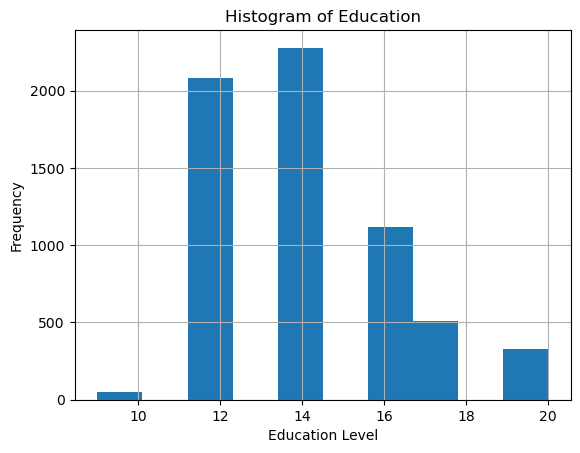

In [6]:
# histogram of education
dta.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

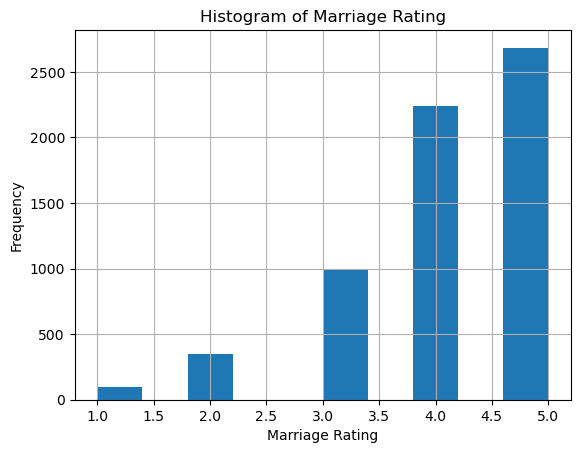

In [7]:
# histogram of marriage rating
dta.rate_marriage.hist()
plt.title('Histogram of Marriage Rating')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Давайте посмотрим на распределение оценок брака среди тех, у кого есть романы, и тех, у кого их нет.

Text(0, 0.5, 'Frequency')

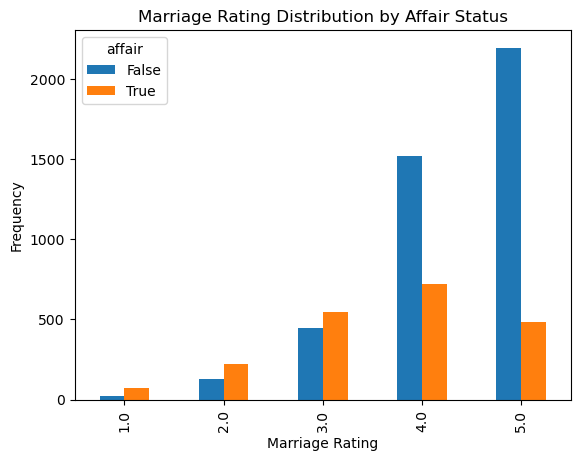

In [8]:
# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(dta.rate_marriage, dta.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Давайте воспользуемся stacked barplot (линейчатой диаграммой с накоплением), чтобы посмотреть на процент женщин, состоящих в отношениях, по количеству лет брака.

Text(0, 0.5, 'Percentage')

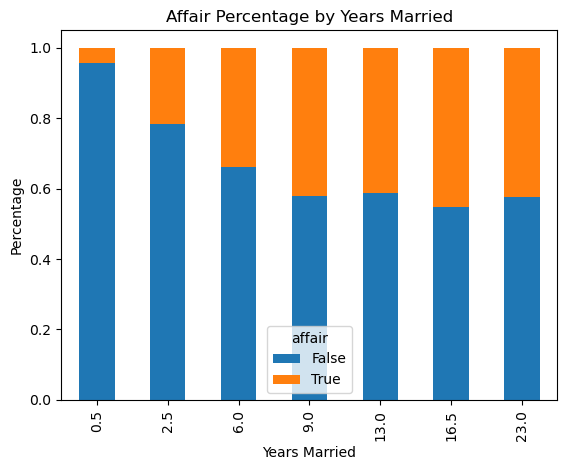

In [9]:
affair_yrs_married = pd.crosstab(dta.yrs_married, dta.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')

## Подготовка данных для логистической регрессии
Чтобы подготовить данные, я хочу добавить столбец Intercept, а также dummy переменные для occupation и occupation_husb, так как я рассматриваю их как категориальные переменные. Функция dmatrices из модуля patsy может сделать это, используя язык формул.

In [10]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + \
                  religious + educ + C(occupation) + C(occupation_husb)',
                  dta, return_type="dataframe")
print (X.columns)

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')


Имена столбцов для фиктивных переменных уродливы, поэтому давайте переименуем их.

In [11]:
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

Нам также нужно преобразовать Y в одномерный массив, чтобы scikit-learn правильно понял его как переменную ответа.

In [12]:
# flatten y into a 1-D array
y = np.ravel(y)

## Логистическая регрессия
Давайте продолжим и запустим логистическую регрессию для всего набора данных и посмотрим, насколько она точна!

In [13]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

C:\Users\zuboc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7257304429783223

Точность 73% кажется хорошей, но какова частота нулевых ошибок?

In [14]:
# what percentage had affairs?
y.mean()

0.3224945020420987

Только у 32% женщин были романы, а это означает, что вы можете получить точность 68%, всегда предсказывая «нет». Таким образом, у нас дела обстоят лучше, чем при нулевой частоте ошибок, но ненамного.

Давайте рассмотрим коэффициенты, чтобы увидеть, что мы узнаем.

In [15]:
# examine the coefficients
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[1.4446573895728592]
1,occ_2,[0.11658867731409896]
2,occ_3,[0.3707600536924948]
3,occ_4,[0.12746020282177162]
4,occ_5,[0.7108647999278704]
5,occ_6,[0.3334330686142531]
6,occ_husb_2,[0.28069375335385033]
7,occ_husb_3,[0.40653767753439696]
8,occ_husb_4,[0.24731287013795222]
9,occ_husb_5,[0.280405138979456]


Увеличение рейтинга брака и религиозности соответствует уменьшению вероятности романа. Как для профессии жены, так и для профессии мужа наименьшая вероятность романа соответствует базовой профессии (студент), поскольку все dummy коэффициенты положительны.

## Оценка модели с использованием валидационных данных
До сих пор мы тренировались и тестировались на одном и том же наборе. Вместо этого давайте разделим данные на обучающий набор и набор для тестирования.

In [16]:
# evaluate the model by splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model2 = LogisticRegression()
model2.fit(X_train, y_train)

C:\Users\zuboc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Теперь нам нужно предсказать метки классов для тестового набора. Мы также сгенерируем вероятности классов, просто чтобы посмотреть.

In [17]:
# predict class labels for the test set
predicted = model2.predict(X_test)
print (predicted)

[1. 0. 0. ... 0. 0. 0.]


In [18]:
# generate class probabilities
probs = model2.predict_proba(X_test)
print (probs)

[[0.34732079 0.65267921]
 [0.90615996 0.09384004]
 [0.72157292 0.27842708]
 ...
 [0.54306016 0.45693984]
 [0.8184939  0.1815061 ]
 [0.74162351 0.25837649]]


Как видите, классификатор предсказывает 1 (измена) каждый раз, когда вероятность во втором столбце больше 0,5.

Теперь давайте сгенерируем некоторые метрики оценки.

In [19]:
# generate evaluation metrics
print (metrics.accuracy_score(y_test, predicted))
print (metrics.roc_auc_score(y_test, probs[:, 1]))

0.7298429319371728
0.7474336880674557


Точность составляет 73%, что соответствует тому, что мы получили при обучении и прогнозировании на тех же данных.

Мы также можем увидеть conf матрицу  и отчет о классификации с другими метриками.

In [20]:
print (metrics.confusion_matrix(y_test, predicted))
print (metrics.classification_report(y_test, predicted))

[[1171  132]
 [ 384  223]]
              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82      1303
         1.0       0.63      0.37      0.46       607

    accuracy                           0.73      1910
   macro avg       0.69      0.63      0.64      1910
weighted avg       0.71      0.73      0.71      1910



## Оценка модели с использованием перекрестной проверки
Теперь давайте попробуем 10-кратную перекрестную проверку, чтобы увидеть, сохраняется ли точность более строго.

In [21]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print (scores)
print (scores.mean())

C:\Users\zuboc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\zuboc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[0.72056515 0.69544741 0.73626374 0.70800628 0.71742543 0.72841444
 0.72798742 0.70597484 0.75314465 0.75157233]
0.724480169426261


C:\Users\zuboc\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Выглядит неплохо. По-прежнему работает с точностью 73%.

## Прогнозирование вероятности романа
Ради интереса давайте предскажем вероятность романа для случайной женщины, не представленной в наборе данных. Она 25-летняя учительница, окончившая колледж, замужем 3 года, имеет 1 ребенка, считает себя глубоко религиозной, считает свой брак справедливым, а ее муж - фермер.

In [22]:
model.predict_proba(np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 3, 25, 3, 1, 4, 16]).reshape(1, -1))

C:\Users\zuboc\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([[0.77251471, 0.22748529]])

Прогнозируемая вероятность романа составляет 23%.